# MNIST MLP

Back 2 basix.

## Setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
from physics_mi.eval import plot_loss
from torch import nn
from tqdm.notebook import tqdm

In [3]:
class config:
    EPOCHS = 50
    LR = 1e-3

## Data

In [4]:
trainset = torchvision.datasets.MNIST(root="./data", train=True, download=True, transform=transforms.ToTensor())
testset = torchvision.datasets.MNIST(root="./data", train=False, download=True, transform=transforms.ToTensor())

In [5]:
train_dl = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valid_dl = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [6]:
xb, yb = next(iter(train_dl))

## Model

In [7]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=16, output_dim=2, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, output_dim, use_act=False),
        )

    def forward(self, x):
        x = x.view(x.shape[0], -1)  # cba messing with the dataset that's already neatly packaged
        return self.layers(x)

## Training

In [10]:
from torch.optim import Adam
from torch.optim.lr_scheduler import OneCycleLR

model = model = Net(input_dim=784, hidden_dim=64, output_dim=10)
optimiser = Adam(model.parameters(), lr=config.LR, weight_decay=1e-2)
loss_func = nn.CrossEntropyLoss()
total_steps = len(train_dl) * config.EPOCHS
scheduler = OneCycleLR(optimiser, max_lr=config.LR, total_steps=total_steps)

log = []

for epoch in tqdm(range(config.EPOCHS)):
    log_sample = {}

    model.train()
    for xb, yb in train_dl:
        y_hat = model(xb)
        loss = loss_func(y_hat, yb)
        loss.backward()
        optimiser.step()
        optimiser.zero_grad()
        scheduler.step()

    model.eval()
    valid_loss = 0
    for xb, yb in valid_dl:
        with torch.no_grad():
            y_hat = model(xb)
            valid_loss += loss_func(y_hat, yb)

    log_sample["valid_loss"] = float(valid_loss / len(valid_dl))
    log_sample["train_loss"] = float(loss)
    log.append(log_sample)

log = pd.DataFrame(log)

  0%|          | 0/50 [00:00<?, ?it/s]

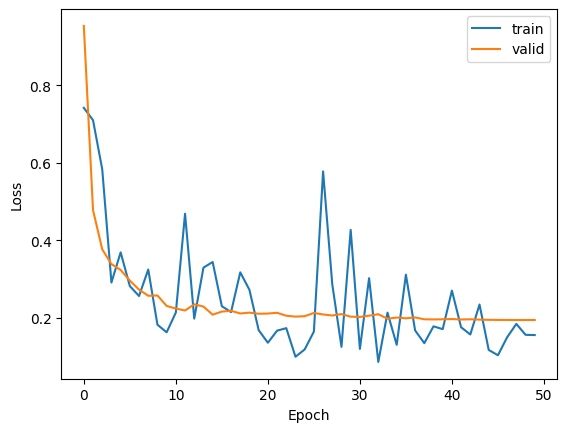

In [11]:
plot_loss(log["train_loss"], log["valid_loss"])

## Results

In [13]:
def get_preds(model, valid_dl):
    model.eval()

    y_preds = []
    y_targs = []

    for xb, yb in valid_dl:
        with torch.inference_mode():
            out = model(xb)
        y_preds.append(out)
        y_targs.append(yb)

    y_preds = torch.cat(y_preds).numpy()
    y_targs = torch.cat(y_targs).numpy()

    return y_preds, y_targs

In [17]:
y_preds, y_targs = get_preds(model, valid_dl)
y_preds = y_preds.argmax(axis=1)

In [18]:
(y_preds == y_targs).mean()

0.9526

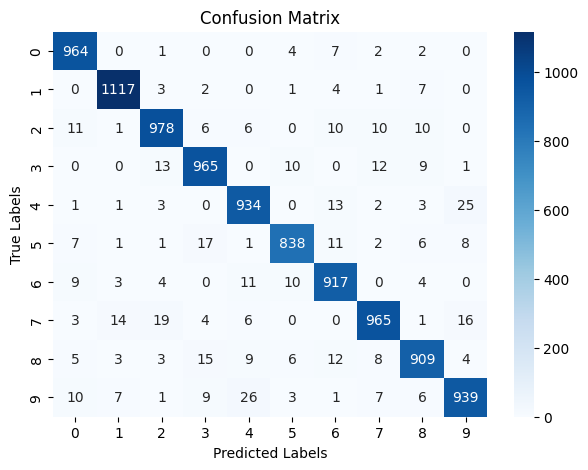

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_targs, y_preds)

# Plotting the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="g")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

To me, this feels good enough to roll with.

In [22]:
# torch.save(model.state_dict(), "models/mnist-mlp.pth")

## Task independence

I'm keen to produce some plots like I did in `007-comp-graph/005-soft-mixing`.

In [8]:
from physics_mi.analysis import capture_intermediate_outputs
from physics_mi.graph import generate_graph
from physics_mi.analysis import plot_similarity_matrix, get_sims

In [9]:
model = Net(input_dim=784, hidden_dim=64, output_dim=10)
model.load_state_dict(torch.load("models/mnist-mlp.pth"))

<All keys matched successfully>

In [10]:
X_valid = torch.cat([xb for xb, _ in valid_dl])
X_valid.shape

torch.Size([10000, 1, 28, 28])

In [11]:
valid_ios = capture_intermediate_outputs(model, X_valid)
valid_ios["input"] = X_valid

In [12]:
class ScaffoldNet(Net):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.requires_grad_(False)

    def forward(self, lidx, linputs):
        sub_net = self.layers[lidx : lidx + 1]
        out = sub_net(linputs)
        return out


scaffold_model = ScaffoldNet(input_dim=784, hidden_dim=64, output_dim=10)
scaffold_model.load_state_dict(model.state_dict())

<All keys matched successfully>

In [13]:
ios = valid_ios
layer_keys = [
    "input",
    "layers.0.act",
    "layers.1.act",
    "layers.2.linear.bias",
]  # these are where from we would like to extract the components

This takes _ages_ - I guess it's a high(er) dimensional output and input.

In [ ]:
ndf, edf = generate_graph(ios, layer_keys, scaffold_model)

In [ ]:
sims = get_sims(ndf, layer_keys[0])
plot_similarity_matrix(sims)